In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

In [26]:
train = pd.read_csv("./realtrain.csv")
test = pd.read_csv("./test.csv")

In [5]:
# 돌연변이를 1, WT를 0으로 변환
def encode_mutations(df):
    for col in df.columns[1:]:  # 'ID'를 제외한 모든 열
        df[col] = df[col].apply(lambda x: 0 if x == 'WT' else 1)
    return df

In [6]:
train = encode_mutations(train)
test = encode_mutations(test)

In [7]:
# 타겟 변수와 피처 분리
X = train.drop(columns=['ID', 'BGN'])  
y = train['BGN']

In [8]:
# 분류 성능 비교 및 변수 선택
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Lasso 분류기 - 변수 선택
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
lasso = LassoCV(cv=5, random_state=42, max_iter=5000, alphas=np.logspace(-4, 1, 50)).fit(X_train_scaled, y_train)
lasso_selector = SelectFromModel(lasso, prefit=True)
X_train_lasso = lasso_selector.transform(X_train_scaled)
X_test_lasso = lasso_selector.transform(X_test_scaled)

In [11]:
lasso_selected_features = X.columns[lasso_selector.get_support()]

In [12]:
# Lasso 모델 성능 평가
lasso_predictions = lasso.predict(X_test_scaled)
lasso_performance = accuracy_score(y_test, np.round(lasso_predictions))

-----------------------------------------------------

In [13]:
# XGBoost 분류기 - 변수 선택
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42)
xgb_model.fit(X_train, y_train)
xgb_selected_features = X.columns[xgb_model.feature_importances_ > np.mean(xgb_model.feature_importances_)]

In [14]:
# XGBoost 모델 성능 평가
xgb_predictions = xgb_model.predict(X_test)
xgb_performance = accuracy_score(y_test, xgb_predictions)

In [15]:
# 공통적으로 탐색된 변수 확인
common_features = set(lasso_selected_features).intersection(xgb_selected_features)
print("공통적으로 탐색된 변수:", common_features)

공통적으로 탐색된 변수: {'SLIT1', 'LRRC15', 'HKDC1', 'GDA', 'MAOA', 'KLK7', 'MMP1', 'PTGIS', 'AGER', 'E2F1', 'B2M', 'GALNT3', 'HOXC10', 'EZH2'}


In [16]:
# 탐색된 변수들에 대한 신뢰성 평가
final_X_train = X_train[list(common_features)]
final_X_test = X_test[list(common_features)]

In [17]:
# Lasso 모델 성능 평가 (공통 변수만 사용)
lasso.fit(final_X_train, y_train)
final_lasso_predictions = lasso.predict(final_X_test)
final_lasso_performance = accuracy_score(y_test, np.round(final_lasso_predictions))

In [18]:
# XGBoost 모델 성능 평가 (공통 변수만 사용)
xgb_model.fit(final_X_train, y_train)
final_xgb_predictions = xgb_model.predict(final_X_test)
final_xgb_performance = accuracy_score(y_test, final_xgb_predictions)

In [19]:
print("Lasso 최종 성능 평가:", final_lasso_performance)
print("XGBoost 최종 성능 평가:", final_xgb_performance)

Lasso 최종 성능 평가: 0.9943593875906527
XGBoost 최종 성능 평가: 0.9927477840451249


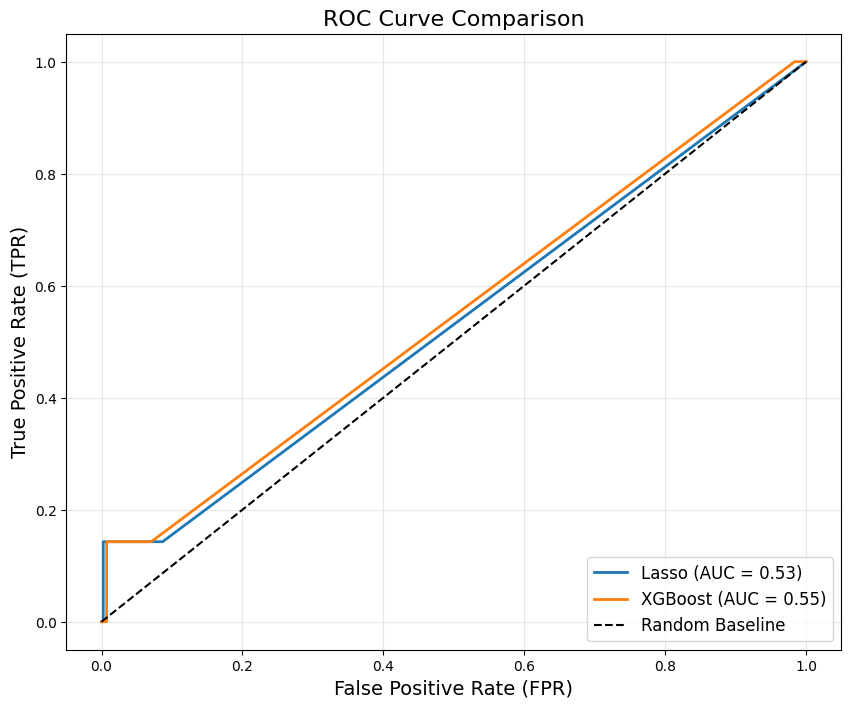

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Lasso 모델에 대한 예측 확률 계산
lasso_probabilities = lasso.predict(final_X_test)

# XGBoost 모델에 대한 예측 확률 계산
xgb_probabilities = xgb_model.predict_proba(final_X_test)[:, 1]  # 양성 클래스 확률만 사용



# ROC 커브 계산
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso_probabilities)
auc_lasso = auc(fpr_lasso, tpr_lasso)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probabilities)
auc_xgb = auc(fpr_xgb, tpr_xgb)


# ROC 커브 시각화
plt.figure(figsize=(10, 8))
plt.plot(fpr_lasso, tpr_lasso, label=f'Lasso (AUC = {auc_lasso:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linewidth=2)


# 기준선 (랜덤 분류)
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

# 그래프 설정
plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()
